In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import os

Reading JLA covariance matrix and examinate the min, max and mean from it. 

In [2]:
syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))

-0.0166258178256 0.0347767817719 0.0025805871334024376


Heat map to cov matrix:

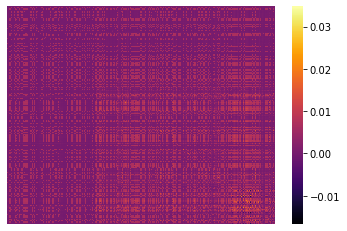

In [3]:
dfcov = pd.DataFrame(syscov)
sns.heatmap(dfcov, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')

Verify that the cov matrix is symmetrical:

In [4]:
count = 0
for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
            print(i,j)
            print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]
print(count)

0 10
9.33387814202e-05 9.33387814201e-05
0 75
9.05443602016e-05 9.05443602015e-05
2 68
5.84269431267e-05 5.84269431266e-05
3 107
0.000136763299594 0.000136763299593
3 175
6.821596824e-05 6.82159682399e-05
4 19
0.000218987354692 0.000218987354691
7 224
6.57226796625e-05 6.57226796624e-05
8 13
9.57880153294e-05 9.57880153295e-05
8 26
0.00661609551033 0.00661609551034
8 96
0.000253469634018 0.000253469634019
8 154
9.9063520192e-05 9.90635201921e-05
8 227
-3.79691626194e-06 -3.79691626193e-06
8 231
0.000255139378748 0.000255139378749
9 157
6.23071374699e-05 6.23071374698e-05
10 116
5.51821214604e-05 5.51821214603e-05
12 198
6.16747798165e-05 6.16747798164e-05
13 18
7.67427279413e-05 7.67427279412e-05
13 121
9.04513387774e-05 9.04513387773e-05
13 218
6.97373549281e-05 6.9737354928e-05
14 68
3.2722108844e-06 3.27221088441e-06
14 81
9.91102935493e-06 9.91102935494e-06
14 85
-1.71950071068e-07 -1.71950071066e-07
15 92
0.000216399317748 0.000216399317747
17 172
1.76995240946e-07 1.76995240947e-

Add the statistical error to the diag of the covariance matrix:

In [5]:
file = 'data/jla_lcparams.txt'

data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
X = data.values[:,0]
staterr = data.values[:,2]
covfull = np.copy(syscov)
covfull[np.diag_indices_from(covfull)] += staterr**2
print(np.shape(syscov), np.shape(covfull))
mincov = np.min(covfull)
maxcov = np.max(covfull)
meancov = np.mean(covfull)
print(mincov, maxcov, meancov)

(740, 740) (740, 740)
-0.0166258178256 0.0633448802129 0.0025992186787941202


See the new covariance matrix:

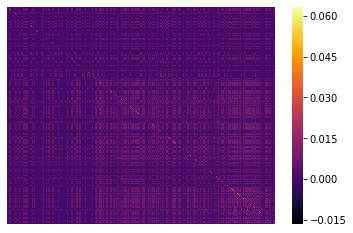

In [6]:
df_covfull = pd.DataFrame(covfull)
sns.heatmap(df_covfull, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno',
            vmax=maxcov, vmin=mincov)
# ,robust=True)

Extract eigenvalues and eigen vectors. Show the eigenvector matrix.

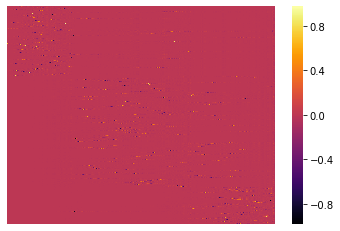

In [7]:
eigenval, eigenvec = sp.linalg.eigh(covfull)
df_eig = pd.DataFrame(eigenvec)
sns.heatmap(df_eig, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno')
#             robust=True)

Orthonormalization of the eigenvector matrix

In [8]:
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

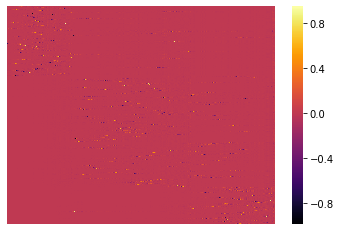

In [9]:
ortM = np.array(gram_schmidt_columns(np.real(eigenvec)))
sns.heatmap(pd.DataFrame(ortM), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno') 
#             robust=True)

## Here starts the VAE network

- Original input is the data len for JLA compilation-
- We try with 3 hidden layer
- We want that the latent space has 1 dimension to make a mapping with the redshift

In [10]:
original_dim = 740
intermediate_dim1 = 600
intermediate_dim2 = 200
intermediate_dim3 = 50
latent_dim = 1

inputs = tf.keras.Input(shape=(original_dim,))

h = layers.Dense(intermediate_dim1, activation='relu')(inputs)
h2 = layers.Dense(intermediate_dim2, activation='relu')(h)
h3 = layers.Dense(intermediate_dim3, activation='relu')(h2)
z_mean = layers.Dense(latent_dim)(h3)
z_log_sigma = layers.Dense(latent_dim)(h3)

### Define a sampling method

In [11]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.0, stddev=0.05)
    return z_mean + K.exp(z_log_sigma) * epsilon

Create a Lambda layer with z_mean, z_log_sigma and sampling method **

In [12]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [13]:
# Create encoder model
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim1, activation='relu')(latent_inputs)
x2 = layers.Dense(intermediate_dim2, activation='relu')(x)
x3 = layers.Dense(intermediate_dim3, activation='relu')(x2)

# Last layer returns original dimension
outputs = layers.Dense(original_dim, activation='relu')(x3)

# Decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

## Instantiate loss functions

- Reconstruction loss
- Kullback-Leiber divergence
- VAE loss

In [14]:
# reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [15]:
# Analize ortM
meanM = np.max(ortM)
stdM = np.std(ortM)
print(" max: {} \n min: {} \n mean: {} \n "
      "std: {} \n median: {} \n "
      .format(np.max(ortM), np.min(ortM), meanM, stdM, np.median(ortM)))

 max: 0.9447326625306337 
 min: -0.9801356357866047 
 mean: 0.9447326625306337 
 std: 0.03676073079230063 
 median: -1.8962206707861076e-05 
 


Separate the orthonormalized matrix into train and test set

In [16]:
split = 0.8
ntrain = int(split * len(eigenvec))
indx = [ntrain]
eigscaler = MinMaxScaler(feature_range=(-0.5, 0.5))
# eigscaler = MinMaxScaler(feature_range=(-1e-9, 1e-9))
# eigscaler = StandardScaler()
eigscaler.fit(ortM)
ortM = eigscaler.transform(ortM)
randomize = np.random.permutation(len(eigenvec))
ortM = ortM[randomize]
evec_train, evec_test = np.split(ortM, indx)
evec_train, evec_test = np.split(ortM, indx)

### TRAINING

In [17]:
vae_train = vae.fit(evec_train, evec_train,
        epochs=100,
        batch_size=4,
        shuffle=True,
        validation_data=(evec_test, evec_test))

Epoch 1/100
148/148 [==============================] - 1s 4ms/step - loss: 11.7615 - val_loss: 11.1605
Epoch 2/100
148/148 [==============================] - 1s 3ms/step - loss: 11.1996 - val_loss: 11.1609
Epoch 3/100
148/148 [==============================] - 1s 3ms/step - loss: 11.2016 - val_loss: 11.1622
Epoch 4/100
148/148 [==============================] - 1s 3ms/step - loss: 11.1999 - val_loss: 11.1624
Epoch 5/100
148/148 [==============================] - 1s 4ms/step - loss: 11.2003 - val_loss: 11.1731
Epoch 6/100
148/148 [==============================] - 1s 3ms/step - loss: 11.1992 - val_loss: 11.1640
Epoch 7/100
148/148 [==============================] - 1s 3ms/step - loss: 11.1991 - val_loss: 11.1607
Epoch 8/100
148/148 [==============================] - 0s 3ms/step - loss: 11.1987 - val_loss: 11.1653
Epoch 9/100
148/148 [==============================] - 0s 3ms/step - loss: 11.1981 - val_loss: 11.1577
Epoch 10/100
148/148 [==============================] - 0s 3ms/step - los

Epoch 80/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6336 - val_loss: 10.6072
Epoch 81/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6311 - val_loss: 10.6009
Epoch 82/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6318 - val_loss: 10.5982
Epoch 83/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6325 - val_loss: 10.6056
Epoch 84/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6330 - val_loss: 10.6021
Epoch 85/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6315 - val_loss: 10.6007
Epoch 86/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6335 - val_loss: 10.6054
Epoch 87/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6276 - val_loss: 10.5903
Epoch 88/100
148/148 [==============================] - 0s 3ms/step - loss: 10.6210 - val_loss: 10.5859
Epoch 89/100
148/148 [==============================] - 0s 3ms/s

### Evaluate performance

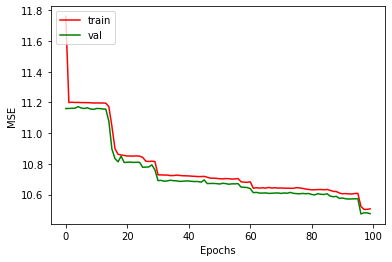

In [18]:
plt.plot(vae_train.history['loss'], color='r')
plt.plot(vae_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

Looking the latent space

(3, 148, 1) <class 'list'>


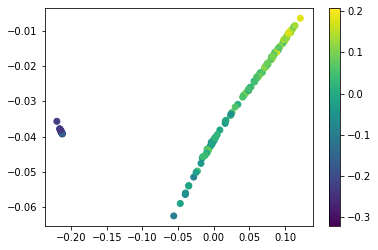

In [19]:
evec_test_encoded = encoder.predict(evec_test)
# plt.figure(figsize=(6, 6))
plt.scatter(evec_test_encoded[0], evec_test_encoded[1], c=evec_test_encoded[2])
plt.colorbar()
# plt.show()
print(np.shape(evec_test_encoded), type(evec_test_encoded))

Analize bounds of latent space:

In [20]:
# encoded_vals = encoder.predict(evec_test)
encoded_vals = encoder.predict(ortM)
maxlatent = np.max(encoded_vals)
minlatent = np.min(encoded_vals)

print(np.min(encoded_vals), np.max(encoded_vals), len(encoded_vals))
encoded_vals[2]

-0.3218042 0.22078407 3


array([[ 0.08433008],
       [ 0.08293813],
       [ 0.02604069],
       [ 0.05119712],
       [-0.06825057],
       [ 0.0580701 ],
       [ 0.04557763],
       [-0.20757534],
       [ 0.06927193],
       [-0.21771719],
       [-0.07459718],
       [-0.19003583],
       [ 0.16785336],
       [ 0.05682272],
       [ 0.16104066],
       [-0.25691214],
       [ 0.05805163],
       [ 0.04811063],
       [ 0.01189033],
       [ 0.03896949],
       [ 0.13233612],
       [ 0.02744089],
       [-0.08382788],
       [-0.16190705],
       [-0.2982602 ],
       [-0.03187874],
       [ 0.09277782],
       [ 0.09776808],
       [ 0.12508234],
       [ 0.02462135],
       [-0.0388797 ],
       [ 0.05788681],
       [ 0.0090975 ],
       [-0.04494467],
       [ 0.09737169],
       [-0.17313938],
       [-0.22715425],
       [ 0.07273428],
       [-0.1770044 ],
       [-0.19128017],
       [ 0.03933667],
       [-0.17668469],
       [ 0.00350616],
       [-0.13004714],
       [ 0.12890866],
       [ 0

## Generate synthetic covariance matrix

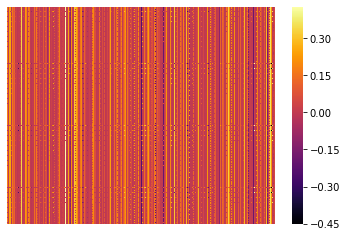

In [21]:
r = np.random.uniform(minlatent, maxlatent, size=740)
# r = np.linspace(minlatent, maxlatent, 740)
# rs = eigscaler.transform(r)
pred_random = decoder.predict(encoded_vals[2])
pred_random = eigscaler.inverse_transform(pred_random)
df_pred = pd.DataFrame(pred_random)
sns.heatmap(df_pred, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno') 
#             robust=True')

In [22]:
pred_random

array([[ 2.1365364e-03, -2.6849438e-03,  1.7701375e-01, ...,
         3.4050534e-03,  6.9981851e-03,  4.2699780e-02],
       [ 2.1240741e-03, -2.6849438e-03,  1.7701375e-01, ...,
         2.8216462e-03,  6.8058628e-03,  4.2699780e-02],
       [ 1.4072441e-03, -2.6849438e-03,  1.7701375e-01, ...,
        -1.7878804e-02, -2.4484366e-04,  4.2699780e-02],
       ...,
       [ 1.4145854e-03, -2.6849438e-03,  1.7701375e-01, ...,
        -1.7622884e-02, -1.4490576e-04,  4.2699780e-02],
       [ 2.3215006e-03, -2.6849438e-03,  1.7701375e-01, ...,
         1.2811147e-02,  1.0190289e-02,  4.2699780e-02],
       [ 1.6861765e-03, -2.6849438e-03,  1.7701375e-01, ...,
        -7.8582596e-03,  3.2799561e-03,  4.2699780e-02]], dtype=float32)

In [23]:
ortM 

array([[ 0.2713047 ,  0.00187763, -0.14527045, ...,  0.32340317,
         0.46828772,  0.06165499],
       [ 0.27112269,  0.00198382, -0.14508914, ...,  0.2662377 ,
         0.43549628,  0.10648496],
       [ 0.27220974,  0.00287518, -0.14417216, ...,  0.18986968,
         0.30997442, -0.46993222],
       ...,
       [ 0.27103947,  0.00175826, -0.14491195, ...,  0.16978905,
         0.30091806, -0.45569628],
       [ 0.27141707,  0.00197202, -0.14544016, ...,  0.29700544,
         0.45283103,  0.08087072],
       [ 0.28728544,  0.00369782, -0.17163229, ...,  0.32130775,
         0.46613832,  0.06048416]])